cant create folder
cant create folder
cant create folder
1330 13-14.png


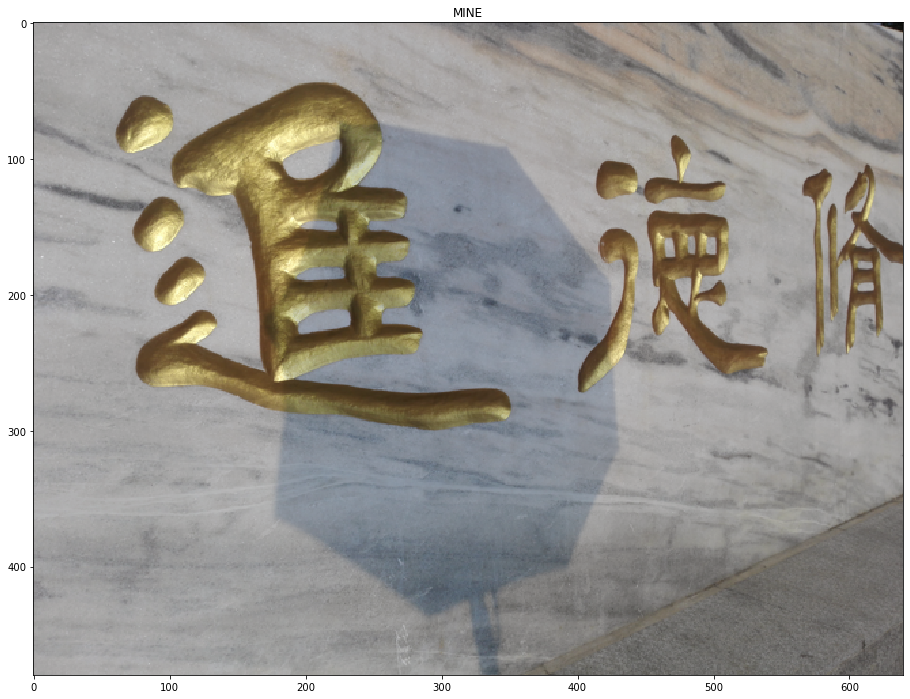

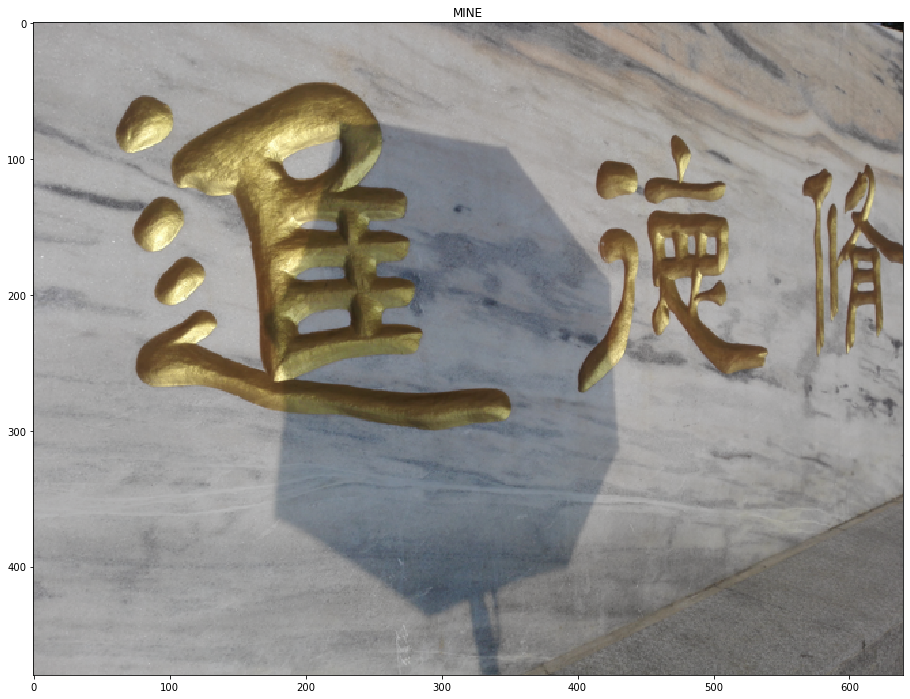

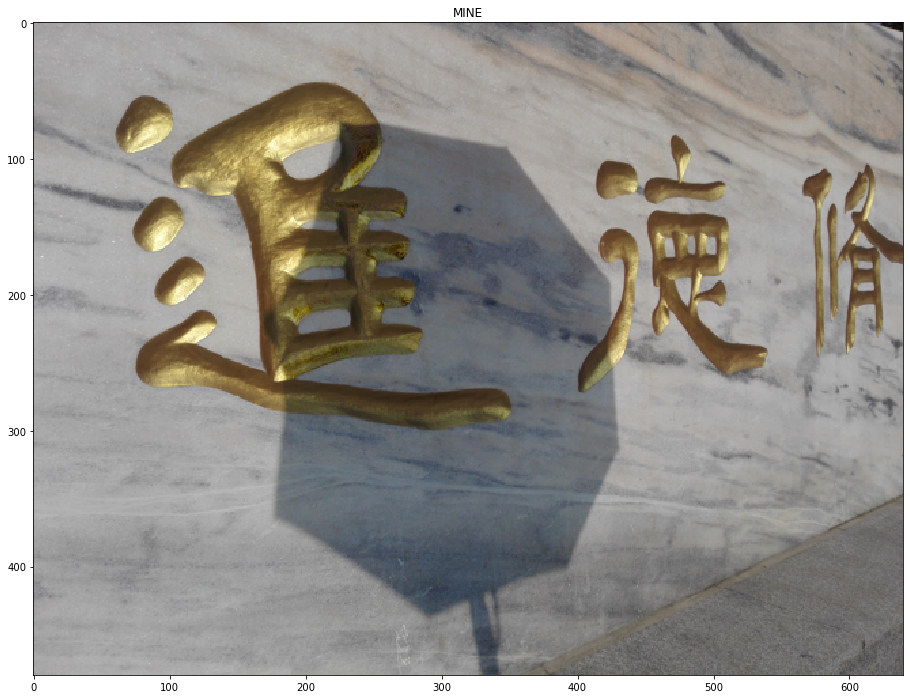

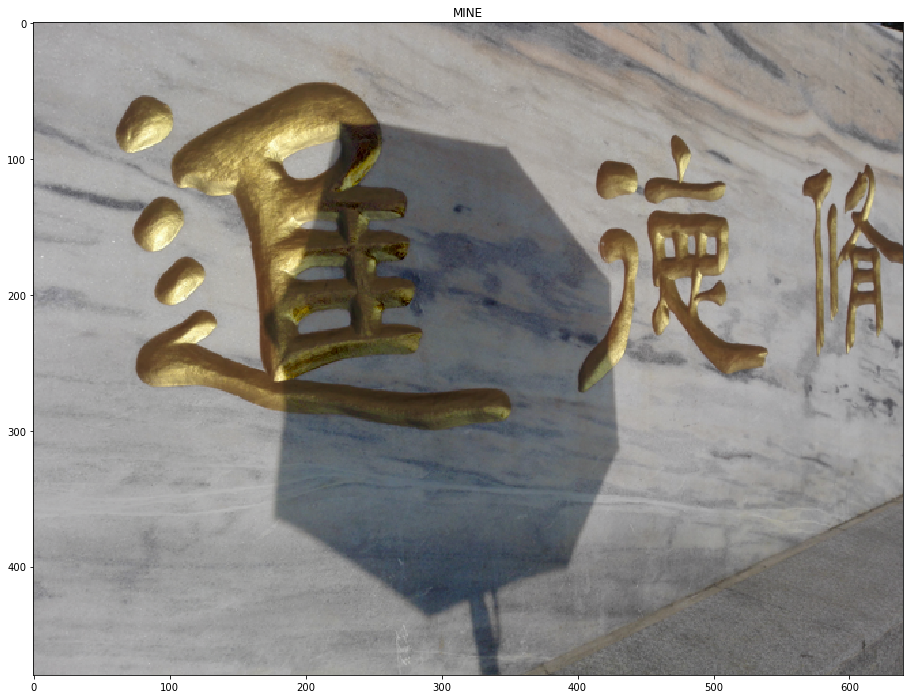

In [11]:
import cv2
import os
from os import listdir
from os.path import isfile, join
from PIL import Image as Image
import numpy as np

from scipy.optimize import curve_fit

def relit(x, a, b):
    return (a * x.astype(np.float)/255 + b)*255



from matplotlib import pyplot as plt
def plshow(im,title='MINE'):
    if len(im.shape)>2:
  #      plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
        plt.imshow(im)
    else:
        plt.imshow(im,cmap='gray')
    plt.title(title)
    plt.rcParams["figure.figsize"] = (80,12)
    plt.show()

sd_path = 'dataset/ISTD/train_A'
mask_path = 'dataset/ISTD/train_B'
sdfree_path = 'dataset/ISTD/train_C_fixed_ours'
out = 'dataset/ISTD/train_param'


des_path = 'dataset/ISTD_augmented/'
for d in ['train_A','train_B','train_C']:
    try:
        os.makedirs(os.path.join(des_path,d))
    except:
        print('cant create folder')
        
        


im_list  =  [f for f in listdir(sd_path) if isfile(join(sd_path, f)) and f.endswith('png')]
print(len(im_list),im_list[0])
kernel = np.ones((5,5),np.uint8)


def im_relit(Rpopt,Gpopt,Bpopt,dump):
    #fc this shit
    sdim = dump.copy()
    sdim.setflags(write=1)
    sdim = sdim.astype(np.float)
    sdim[:,:,0] = (sdim[:,:,0]/255) * Rpopt[0] + Rpopt[1]
    sdim[:,:,1] = (sdim[:,:,1]/255) * Gpopt[0] + Gpopt[1]
    sdim[:,:,2] = (sdim[:,:,2]/255) * Bpopt[0] + Bpopt[1]
    sdim = sdim*255
   # print(np.amin(sdim),np.amax(sdim))
    return sdim

def im_darken(Rpopt,Gpopt,Bpopt,dump,f):
    #fc this shit
    sdim = dump.copy()
    sdim.setflags(write=1)
    sdim = sdim.astype(np.float)
    sdim[:,:,0] = ((sdim[:,:,0]/255) - Rpopt[1]) / (Rpopt[0] * f)
    sdim[:,:,1] = ((sdim[:,:,1]/255) - Gpopt[1]) / (Gpopt[0] * f)
    sdim[:,:,2] = ((sdim[:,:,2]/255) - Bpopt[1]) / (Bpopt[0] * f)
    sdim = sdim*255
   # print(np.amin(sdim),np.amax(sdim))
    return sdim

errors= []
for im in im_list[2:3]:
    sd = np.asarray(Image.open(join(sd_path,im)))
    mean_sdim = np.mean(sd,axis=2)
    
    mask_ori = np.asarray(Image.open(join(mask_path,im)))
    mask = cv2.erode(mask_ori ,kernel,iterations = 2)

    
    sdfree = np.asarray(Image.open(join(sdfree_path,im)))
    mean_sdfreeim = np.mean(sdfree,axis=2)
    
    #pixels for regression funtion
    i, j = np.where(np.logical_and(np.logical_and(np.logical_and(mask>=1,mean_sdim>5),mean_sdfreeim<230),np.abs(mean_sdim-mean_sdfreeim)>10))

    source = sd*0
    source[tuple([i,j])] = sd[tuple([i,j])] 
    target = sd*0
    target[tuple([i,j])]= sdfree[tuple([i,j])]
    
    R_s = source[:,:,0][tuple([i,j])]
    G_s = source[:,:,1][tuple([i,j])]
    B_s = source[:,:,2][tuple([i,j])]
    
    R_t = target[:,:,0][tuple([i,j])]
    G_t = target[:,:,1][tuple([i,j])]
    B_t = target[:,:,2][tuple([i,j])]
    
    c_bounds = [[1,-0.1],[10,0.5]]

    
    Rpopt, pcov = curve_fit(relit, R_s, R_t,bounds=c_bounds)
    Gpopt, pcov = curve_fit(relit, G_s, G_t,bounds=c_bounds)
    Bpopt, pcov = curve_fit(relit, B_s, B_t,bounds=c_bounds)
    
    
    relitim = im_relit(Rpopt,Gpopt,Bpopt,sd)
    
    matte = (relitim - sdfree +1)/ (relitim - sd +1)
    
    F = [0.8,0.9,1.1,1.2]
    for f in F:
        darkenim = im_darken(Rpopt,Gpopt,Bpopt,sdfree,f)
        new_sdim = sdfree * matte + (1-matte) * darkenim
        new_sdim[new_sdim>255] = 255
        new_sdim[new_sdim<0] = 0
        plshow(new_sdim.astype(np.uint))
        
        
        
    
   
                    
    

